In [1]:
'''
(1) Load a collection of spike train pairs.
(2) Inject synchronous spikes onto each pair of spike trains at random times.
(3) Estimate the amount of injected synchronies.
'''

#------------------------------------------------------------------------------
# Imports
#------------------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from ccg import correlograms

#------------------------------------------------------------------------------
# Define Functions
#------------------------------------------------------------------------------
def compthta(Rtemp,Ttemp,delta): # function for computing estimate
    Sobs = len(np.intersect1d(Rtemp,Ttemp))
    mxSpk = np.max(np.append(Rtemp,Ttemp))
    bEdges = np.arange(0,mxSpk,10)
    bo = histc(Rtemp, bEdges) 
    refCounts = np.append(bo[0],0)
    w = np.floor(Ttemp/delta)
    Nr = refCounts[w.astype('int')]
    Nr = Nr[Nr!=0]/delta
    naive = Sobs - np.sum(Nr)
    thtahat = naive/(1-((1/len(Nr))*np.sum(Nr)))
    return thtahat

def histc(X, bins):
    map_to_bins = np.digitize(X,bins)
    r = np.zeros(bins.shape)
    for i in map_to_bins:
        r[i-1] += 1
    return [r, map_to_bins]

def PoissonProcess(intensity,duration,N):
    count = np.random.poisson(lam=intensity,size=N)
    u = np.random.uniform(0,1,size=np.sum(count))
    c = np.int64(np.append(np.zeros(1),np.cumsum(count)))
    T = []
    tag = []
    ind_pos = np.nonzero(count)[0]
    for i in ind_pos:
        T.extend(duration*np.sort(u[c[i]:c[i+1]]))
        tag.extend(i*np.ones(count[i]))
    T = np.asarray(T)
    tag = np.asarray(tag)
                 
    return T,tag

def GenerateInject(train,duration,synch_width,inject_count):
    Nwidth = int(duration/synch_width)
    allwidths = np.arange(Nwidth)
    include_index = np.int64(np.floor(train/synch_width))
    include_idx = list(set(include_index)) 
    mask = np.zeros(allwidths.shape,dtype=bool)
    mask[include_idx] = True
    wheretoinject = synch_width*allwidths[~mask]
    alreadythere = synch_width*allwidths[mask]
    widths = np.append(wheretoinject,alreadythere)
    tags = np.int64(np.append(np.zeros(len(wheretoinject)), np.ones(len(alreadythere))))
    ind_sort = np.argsort(widths)
    widths = widths[ind_sort]
    tags = tags[ind_sort]
    ind_perm = np.int64(np.random.permutation(widths))
    widths = widths[ind_perm]
    tags = tags[ind_perm]
    ind_sort = np.argsort(tags)
    widths = widths[ind_sort]
    tags = tags[ind_sort]    
    train_inject = np.ravel(widths[:inject_count])
    
    return train_inject

#------------------------------------------------------------------------------
# Load spike data
#------------------------------------------------------------------------------

train_ref0 = np.load('train_ref_range.npy')   # Collection of reference spike trains
train_targ0 = np.load('train_targ_range.npy') # Collection of target spike trains
params = np.load('parameters_range.npy')          
Ntrial = int(params[0])                  # Number of trials
duration = params[1]                     # Trial duration in (ms)
period = params[2]                       # Nonstationarity timescale in (ms)
Fs = params[3]

print(params)

#------------------------------------------------------------------------------
# Inject synchronous spikes
#------------------------------------------------------------------------------

synch_width = 1.                                   # Width of synchrony window in (ms)
nb_value = 10
inject_range = np.int64(np.linspace(0,1500,nb_value))
print(inject_range)
duration_new = int(Ntrial*duration/nb_value)
print(duration_new)

Nwidth = int(duration/synch_width)                 # Number of synchrony windows in 
interval = period
Ninterval = int(duration_new/interval)
nb_ref0 = np.bincount(np.int64(np.floor(train_ref0/duration_new)))   
nb_targ0 = np.bincount(np.int64(np.floor(train_targ0/duration_new)))  
i_ref0 = np.int64(np.append(np.zeros(1),np.cumsum(nb_ref0)))
i_targ0 = np.int64(np.append(np.zeros(1),np.cumsum(nb_targ0)))
injection_unbiased = np.zeros(nb_value)
injection_naive = np.zeros(nb_value)
s = np.zeros(nb_value)
nb_inject = []
Rcard = []
yet = 0
for k in range(nb_value):
    Tref0 = train_ref0[i_ref0[k]:i_ref0[k+1]]-k*duration_new
    Ttarg0 = train_targ0[i_targ0[k]:i_targ0[k+1]]-k*duration_new
    T0 = np.append(Tref0,Ttarg0)
    G0 = np.int64(np.append(np.zeros(len(Tref0)), np.ones(len(Ttarg0))))
    Tref0_s = synch_width*np.floor(Tref0/synch_width)  # Discretize reference trains
    Ttarg0_s = synch_width*np.floor(Ttarg0/synch_width)# Discretize target trains
    Tsynch0 = np.array(list(set(Tref0_s) & set(Ttarg0_s)))    # Compute reference-target synchronies' time
    synch_count0 = len(Tsynch0) # Count number of synchronies per trial    
    #s[k] = synch_count0
    inject_count = inject_range[k]           # Amount of injected synchronies
    print(k,inject_count,len(Tref0),len(Ttarg0),synch_count0)
    #Tinj = GenerateInject(T0,duration_new,synch_width,inject_count)
    
    Tinj, label_inj = PoissonProcess(inject_count, duration_new, 1)
    #Tinj = label_inj * duration_new + Tinj
    nb_inject.append(len(Tinj))
    print(len(Tinj))
    
    Tref = np.sort(np.append(Tref0,Tinj))
    Ttarg = np.sort(np.append(Ttarg0,Tinj+0*1.5))
    T = np.append(Tref,Ttarg)
    G = np.int64(np.append(np.zeros(len(Tref)), np.ones(len(Ttarg))))

    # Check whether the injection has been well performed
    lagmax = 50.
    bine = .1
    ind_sort = np.argsort(T0)
    st = T0[ind_sort]*.001
    sc = G0[ind_sort]
    C0 = correlograms(st,sc,sample_rate=Fs,bin_size=bine*10/1000.,window_size=lagmax/1000.)    
    lag0 = (np.arange(len(C0[0,1]))-len(C0[0,1])/2)*bine*10
    ind_sort = np.argsort(T)
    st = T[ind_sort]*.001
    sc = G[ind_sort]
    C = correlograms(st,sc,sample_rate=Fs,bin_size=bine/1000.,window_size=lagmax/1000.)
    lag = (np.arange(len(C[0,1]))-len(C[0,1])/2)*bine
    FigCCGi = plt.figure()
    plt.xlim(-lagmax/2.,lagmax/2.)
    plt.title('Cross-correlogram',fontsize=18)
    plt.xlabel('Time lag  (ms)',fontsize=18)
    plt.ylabel('Firing rate (Hz)',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.bar(lag, C[0,1]/(len(Tref)*bine*.001), bine, align='center', color='k', edgecolor='k', linewidth=2)
    #plt.bar(lag, C0[0,1]/(len(Tref)*bine*.001), bine, align='center', color='None', edgecolor='k', linewidth=2)
    #plt.plot(lag,C[0,1]/(len(Tref)*bine*.001),'.-k')
    plt.plot(lag0,C0[0,1]/(len(Tref0)*bine*10*.001),'--c')
    #plt.show()
    
    #if k == 1:
    print(abs(len(Tinj) - synch_count0))
    if (abs(len(Tinj) - synch_count0) < 50) and (yet == 0):
        print("save figure")
        FigCCGi.savefig('Fig_CCG-injected.eps')
        yet = 1

    # Synchrony cout distribution after injection
    Tref_s = synch_width*np.floor(Tref/synch_width)
    Ttarg_s = synch_width*np.floor(Ttarg/synch_width)
    # Check if multiple spikes at the same time
    _,n = np.unique(Tref_s,return_counts=True)
    indr = np.nonzero(n-np.ones(len(n)))[0]
    _,n = np.unique(Ttarg_s,return_counts=True)
    indt = len(np.nonzero(n-np.ones(len(n)))[0])
    Tsynch = np.array(list(set(Tref_s) & set(Ttarg_s)))
    synch_count = len(Tsynch)
    s[k] = synch_count
    print(synch_count,'s')

    # Predict the amount of injected synchrony
    count_ref = np.bincount(np.int64(np.floor(Tref/interval)), minlength=Ninterval)
    count_targ = np.bincount(np.int64(np.floor(Ttarg/interval)), minlength=Ninterval)
    count_synch = np.bincount(np.int64(np.floor(Tsynch/interval)), minlength=Ninterval)
    RS_prod = np.sum(count_ref*count_synch)
    RT_prod = np.sum(count_ref*count_targ) 
    injection_unbiased[k] = compthta(Tref_s,Ttarg_s,interval) # ZACH MODIFIED TO UNBIASED ESTIMATE, 7/22/2019
    injection_naive[k] = synch_count-RT_prod/interval
#plt.show()
    
# Represent the estimated injected synchrony distribution
print(inject_range/s)
FigTh = plt.figure()
plt.xlabel('True Injected Synchrony Count',fontsize=18)
plt.ylabel('Estimate',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.plot(inject_range/Rcard,inject_range,'--k')
plt.plot(inject_range/Rcard,injection_naive,'D-c', markerfacecolor='None', markeredgecolor='c')
plt.plot(inject_range/Rcard,injection_unbiased,'o-k')
plt.show()






[1.e+03 1.e+05 1.e+01 1.e+04]
[   0  166  333  500  666  833 1000 1166 1333 1500]
10000000
0 0 14599 211779 715
0
715
715 s
1 166 14608 211813 766
158
608
924 s
2 333 14767 211816 754
335
419
1089 s
3 500 14398 211328 698
495
203
1193 s
4 666 14594 212119 763
704
59
1466 s
5 833 14516 211554 736
857
121
1593 s
6 1000 14476 211457 716
967
251
1683 s
7 1166 14753 211505 728
1184
456
1912 s
8 1333 14796 211315 723
1289
566
2012 s
9 1500 14605 211981 736
1559
823
2295 s
[0.         0.17965368 0.30578512 0.41911148 0.45429741 0.52291274
 0.59417706 0.60983264 0.66252485 0.65359477]


ValueError: operands could not be broadcast together with shapes (10,) (0,) 

[0.         0.17945946 0.30410959 0.40783034 0.47982709 0.52357008
 0.57670127 0.61823966 0.63658071 0.66666667]


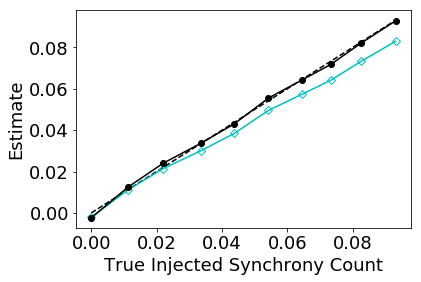

In [20]:
print(inject_range/s)
FigTh = plt.figure()
plt.xlabel('True Injected Synchrony Count',fontsize=18)
plt.ylabel('Estimate',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.plot(np.mean(s)*np.ones(2),[0,1000],'--k')
plt.plot(inject_range/Rcard,inject_range/Rcard,'--k')
plt.plot(inject_range/Rcard,injection_naive/Rcard,'D-c', markerfacecolor='None', markeredgecolor='c')
plt.plot(inject_range/Rcard,injection_unbiased/Rcard,'o-k')
plt.show()



[0.         0.17945946 0.30410959 0.40783034 0.47982709 0.52357008
 0.57670127 0.61823966 0.63658071 0.66666667]


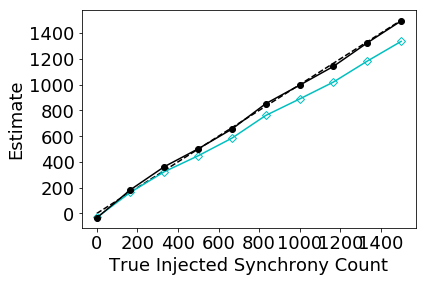

In [21]:
print(inject_range/s)
FigTh = plt.figure()
plt.xlabel('True Injected Synchrony Count',fontsize=18)
plt.ylabel('Estimate',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
#plt.plot(np.mean(s)*np.ones(2),[0,1000],'--k')
plt.plot(inject_range,inject_range,'--k')
plt.plot(inject_range,injection_naive,'D-c', markerfacecolor='None', markeredgecolor='c')
plt.plot(inject_range,injection_unbiased,'o-k')
plt.show()

